We first import all the relevant modules.

In [1]:
import cv2
import os

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

First, we need to calibrate our camera. The camera calibration images are available in 'camera_cal'.

In [2]:
calibration_dir = 'camera_cal'
calibration_images = [os.path.join(calibration_dir, x) for x in os.listdir(calibration_dir)]

As an example, we show what one of these images looks like.

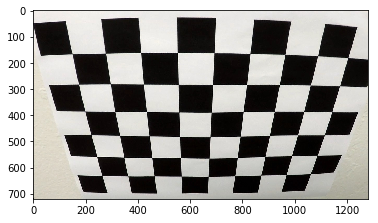

In [3]:
example = plt.imread(calibration_images[6])
plt.imshow(example)

Next, we extract the camera's intrinsic parameters, as well as its radial and tangential distortion.

In [4]:
board_size = (9,6)
objp = np.zeros((board_size[0]*board_size[1],3), np.float32)
objp[:,:2] = np.mgrid[0:board_size[0],0:board_size[1]].T.reshape(-1,2)

objpoints = [] # 3d point in world frame
imgpoints = [] # 2d points in image frame
successful = 0
for fname in calibration_images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, board_size, None)
    if ret == True:
        successful += 1
        objpoints.append(objp)
        imgpoints.append(corners)
print("Found a chessboard in {} out of {} images.".format(successful, len(calibration_images)))
# We will not need the extrinsic parameters.
_, mtx, dist, _, _ = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
print("Finished calibrating.")

Found a chessboard in 17 out of 20 images.
Finished calibrating.


We now show the same picture as above, but undistorted.

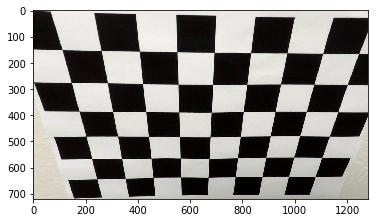

In [5]:
corrected_example = cv2.undistort(example, mtx, dist, None, mtx)
plt.imshow(corrected_example)

Next, we want to extract the lane markings from each frame in the videos. We use the images provided in 'test_images' as a playground for designing this pipeline.

In [6]:
img_dir = 'test_images'
test_images = [os.path.join(img_dir, x) for x in os.listdir(img_dir)]

Here is one of the test images.

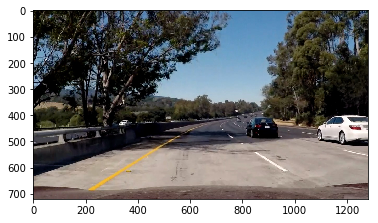

In [7]:
img = plt.imread(test_images[3])
plt.imshow(img)

Our pipeline will consist of a few different things:
1) Undistort the image.
2) Converting the image to HSL and apply thresholding on the S channel.
3) Compute the Sobel gradients of the image and threshold both their magnitude and direction.

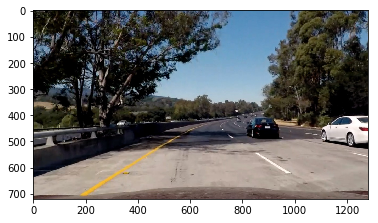

In [8]:
undistorted_img = cv2.undistort(img, mtx, dist, None, mtx)
plt.imshow(undistorted_img)

Now, we will plot the RGB channels of this picture separately.

In [9]:
R = undistorted_img[:,:,0]
G = undistorted_img[:,:,1]
B = undistorted_img[:,:,2]

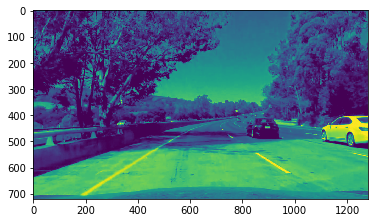

In [10]:
plt.imshow(R)

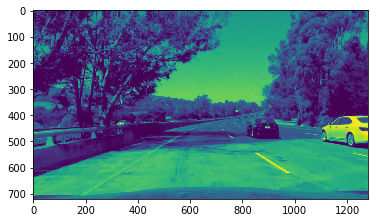

In [11]:
plt.imshow(G)

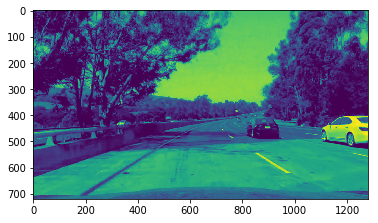

In [12]:
plt.imshow(B)

We will also display the HSL channels.

In [13]:
hls = cv2.cvtColor(undistorted_img, cv2.COLOR_RGB2HLS)
H = hls[:,:,0]
S = hls[:,:,2]
L = hls[:,:,1]

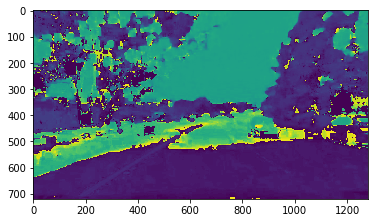

In [14]:
plt.imshow(H)

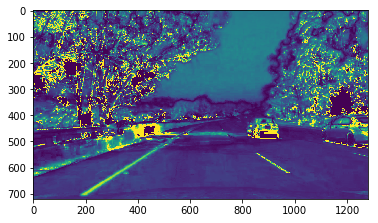

In [15]:
plt.imshow(S)

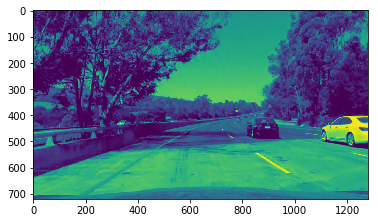

In [16]:
plt.imshow(L)

We will also see how the HSV channels look like.

In [17]:
hsv = cv2.cvtColor(undistorted_img, cv2.COLOR_RGB2HSV)
H2 = hsv[:,:,0]
S2 = hsv[:,:,1]
V = hsv[:,:,2]

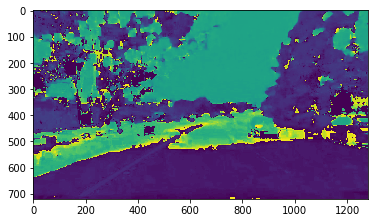

In [18]:
plt.imshow(H2)

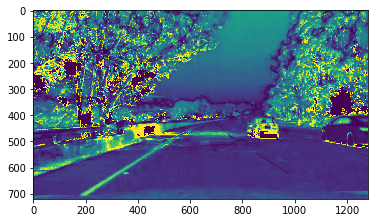

In [19]:
plt.imshow(S2)

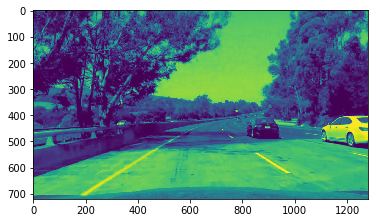

In [20]:
plt.imshow(V)

There seems to be little difference between the S channels of HSL and HSV. Let's stick to HSL.

Now, let's focus on selecting a reasonable region of interest.

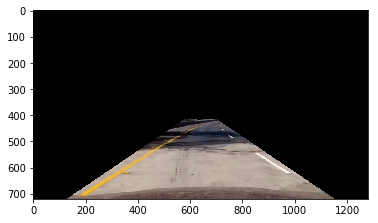

In [21]:
dy, dx = undistorted_img.shape[:2]

RoI_trapezoid = np.array([[ [0.10*dx, dy], [0.90*dx, dy], [0.55*dx, 0.58*dy], [0.45*dx, 0.58*dy] ]], dtype=np.int32)

mask = np.zeros_like(undistorted_img)
cv2.fillPoly(mask, RoI_trapezoid, (255,255,255))

masked = cv2.bitwise_and(undistorted_img, mask)

plt.imshow(masked)

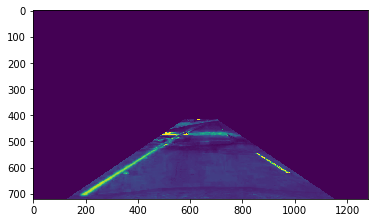

In [22]:
masked_HLS = cv2.bitwise_and(hls, mask)
masked_S = masked_HLS[:,:,2]

plt.imshow(masked_S)

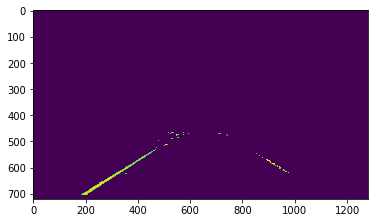

In [23]:
masked_S_in_range = cv2.bitwise_and(masked_S, cv2.inRange(masked_S, 160, 240))

plt.imshow(masked_S_in_range)

Now, we use an alternative method to extract the lane markings: Sobel operators.

In [24]:
def GetFilteredSobel(image, mag_thresh, dir_thresh, ksize):
    sobel_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=ksize)
    sobel_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=ksize)
    sobel_mag_64f = np.hypot(sobel_x, sobel_y)
    sobel_mag_u8 = np.uint8(255*sobel_mag_64f/np.max(sobel_mag_64f))
    sobel_dir = np.arctan2(np.absolute(sobel_y), np.absolute(sobel_x))
    mag_ids = (sobel_mag_u8 >= mag_thresh[0]) & (sobel_mag_u8 <= mag_thresh[1])
    dir_ids = ((sobel_dir >= dir_thresh[0]) & (sobel_dir <= dir_thresh[1]))
    binary_output = np.zeros_like(sobel_mag_u8)
    binary_output[mag_ids & dir_ids] = 1
    return binary_output

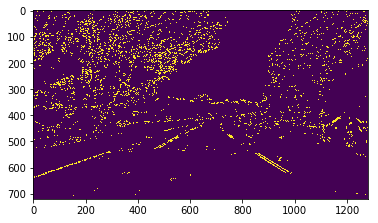

In [25]:
mag_thresh = (30,255)
dir_thresh = (40*np.pi/180, 75*np.pi/180)
ksize=9
plt.imshow(GetFilteredSobel(L, mag_thresh, dir_thresh, ksize))

We now mask this with the region of interest.

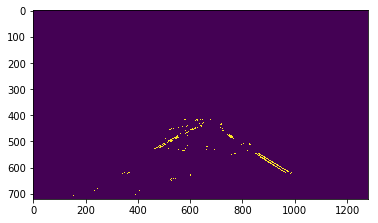

In [26]:
single_channel_mask = np.zeros_like(L)
cv2.fillPoly(single_channel_mask, RoI_trapezoid, (255,))

filtered_sobel = cv2.bitwise_and(GetFilteredSobel(L, mag_thresh, dir_thresh, ksize), single_channel_mask)
plt.imshow(filtered_sobel)

Now, we can combine both methods to give a better understading of where the lane markings are.

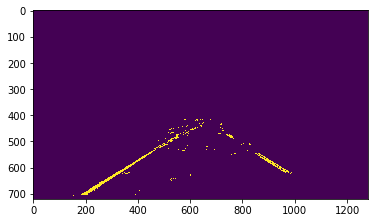

In [27]:
combined = np.copy(filtered_sobel)
combined[masked_S_in_range > 0] = 1

plt.imshow(combined)

We can now aggregate this entire pipeline in a single function, for simplicity in future use.

In [28]:
def ExtractLaneLines(image):
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    s = hls[:,:,2]
    l = hls[:,:,1]
    DY, DX = s.shape[:2]
    ROI = np.array([[ [0.10*DX, DY], [0.90*DX, DY], [0.55*DX, 0.58*DY], [0.45*DX, 0.58*DY] ]], dtype=np.int32)
    MASK = np.zeros_like(s)
    cv2.fillPoly(MASK, ROI, (255,))
    S_RANGE = (160, 240)
    lanes_from_s_channel = cv2.inRange(cv2.bitwise_and(s, MASK), S_RANGE[0], S_RANGE[1])
    MAG_THRESH = (30,255)
    DIR_THRESH = (40*np.pi/180, 75*np.pi/180)
    KSIZE=9
    lanes_from_sobel = cv2.bitwise_and(GetFilteredSobel(l, MAG_THRESH, DIR_THRESH, KSIZE), MASK)
    combined = np.copy(lanes_from_sobel)
    combined[lanes_from_s_channel > 0] = 1
    return combined

def UndistortAndExtractLaneLines(image):
    undistorted = cv2.undistort(img, mtx, dist, None, mtx)
    return ExtractLaneLines(undistorted)

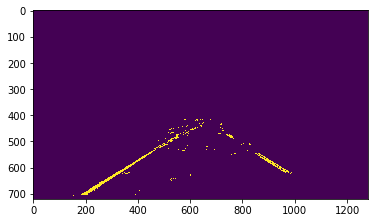

In [29]:
plt.imshow(ExtractLaneLines(undistorted_img))

We now want to do a perspective transform to get a bird's eye view of the lanes.

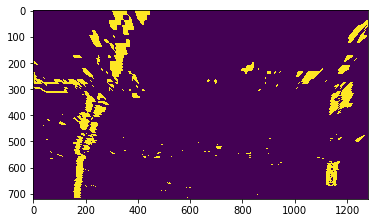

In [44]:
dy, dx = to_transform.shape[:2]
src = np.float32([ [0.10*dx, dy], [0.90*dx, dy], [0.55*dx, 0.63*dy], [0.45*dx, 0.63*dy] ])
dst = np.float32([ [0.10*dx, dy], [0.90*dx, dy], [0.90*dx, 0], [0.10*dx, 0.] ])
M = cv2.getPerspectiveTransform(src, dst)
M_inv = np.linalg.inv(M)

def GetBirdsEye(to_transform):
    return cv2.warpPerspective(to_transform, M, (dx, dy))

def RevertBirdsEye(to_transform):
    return cv2.warpPerspective(to_transform, M_inv, (dx, dy))

to_transform = ExtractLaneLines(undistorted_img)
birds_eye = GetBirdsEye(to_transform)
plt.imshow(birds_eye)

At this point, the main task in hand is to interpolate the two lane lines by quadratic polynomials.

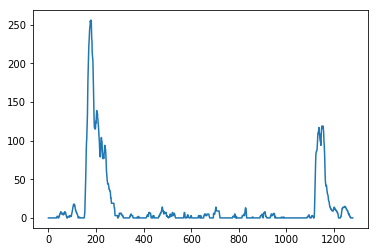

In [45]:
histogram = np.sum(birds_eye[birds_eye.shape[0]//2:,:], axis=0)
plt.plot(histogram)

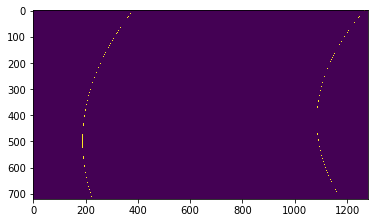

In [161]:
#TODO: sliding window search + polynomial interpolation
#TODO: try RANSAC

def PlotQuadLines(height, width, p_left, p_right):
    Y_linspace = np.linspace(0, height-1, height, dtype=np.int32)
    p_left_img = p_left(Y_linspace)
    p_right_img = p_right(Y_linspace)
    p_left_points = np.array([Y_linspace, np.int32(np.round(p_left_img))]).T
    p_right_points = np.array([Y_linspace, np.int32(np.round(p_right_img))]).T
    left_points_filtered = p_left_points[p_left_points[:,1] < width]
    right_points_filtered = p_right_points[p_right_points[:,1] < width]
    poly_frame = np.zeros([height, width])
    poly_frame[left_points_filtered[:,0], left_points_filtered[:,1]] = 1.0
    poly_frame[right_points_filtered[:,0], right_points_filtered[:,1]] = 1.0
    return np.uint8(255 * poly_frame)

def InterpolateLines(top_view):
    height, width = top_view.shape
    left_points = np.argwhere(top_view[:,:width//2] > 0)
    right_points = np.argwhere(top_view[:,width//2:] > 0)
    X_left = left_points[:,1]
    Y_left = left_points[:,0]
    X_right = right_points[:,1] + width//2
    Y_right = right_points[:,0]
    p_left = np.poly1d(np.polyfit(Y_left, X_left, 2))
    p_right = np.poly1d(np.polyfit(Y_right, X_right, 2))
    return PlotQuadLines(height, width, p_left, p_right)

out = InterpolateLines(birds_eye)
plt.imshow(out)

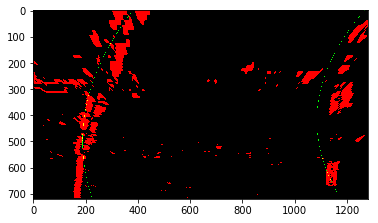

In [141]:
overlay = np.dstack([255*birds_eye, out, np.zeros_like(birds_eye)])
plt.imshow(overlay)

We will now use RANSAC to better adjust the lines that we calculated.

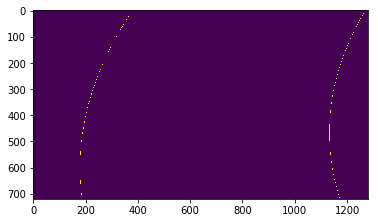

In [178]:
def RANSAC(top_view):
    height, width = top_view.shape
    left_points = np.argwhere(top_view[:,:width//2] > 0)
    right_points = np.argwhere(top_view[:,width//2:] > 0)
    X_left = left_points[:,1]
    Y_left = left_points[:,0]
    X_right = right_points[:,1] + width//2
    Y_right = right_points[:,0]
    both_points = np.zeros_like(top_view)
    p_left = np.poly1d(np.polyfit(Y_left, X_left, 2))
    p_right = np.poly1d(np.polyfit(Y_right, X_right, 2))
    left_mask = np.zeros_like(top_view)
    right_mask = np.zeros_like(top_view)
    I, J = np.meshgrid(np.arange(width), np.arange(height))
    margins = [200, 150, 100, 50]
    for margin in margins:
        left_mask[np.where((I >= p_left(J)-margin) & (I <= p_left(J)+margin))] = 1.0
        right_mask[np.where((I >= p_right(J)-margin) & (I <= p_right(J)+margin))] = 1.0
        left_points = np.argwhere((top_view > 0) & (left_mask > 0))
        right_points = np.argwhere((top_view > 0) & (right_mask > 0))
        X_left = left_points[:,1]
        Y_left = left_points[:,0]
        X_right = right_points[:,1] # no need to sum width//2 here
        Y_right = right_points[:,0]
        p_left = np.poly1d(np.polyfit(Y_left, X_left, 2))
        p_right = np.poly1d(np.polyfit(Y_right, X_right, 2))
    return p_left, p_right

p_left, p_right = RANSAC(birds_eye)

ransac_out = PlotQuadLines(birds_eye.shape[0], birds_eye.shape[1], p_left, p_right)
plt.imshow(ransac_out)

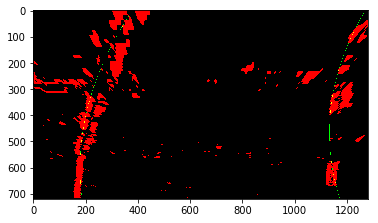

In [179]:
ransac_overlay = np.dstack([255*birds_eye, ransac_out, np.zeros_like(birds_eye)])
plt.imshow(ransac_overlay)

It is quite noticeable that RANSAC works significantly better than simple interpolation.
To make things prettier, we can remove the bad red markings and color the lane as blue.

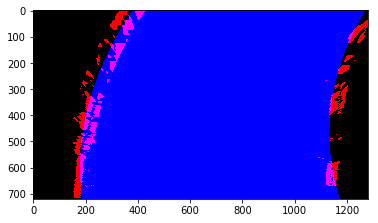

In [191]:
def GetNiceOverlay(top_view):
    height, width = top_view.shape
    p_left, p_right = RANSAC(top_view)
    left_mask = np.zeros_like(top_view)
    right_mask = np.zeros_like(top_view)
    lane = np.zeros_like(top_view)
    margin = 50
    I, J = np.meshgrid(np.arange(width), np.arange(height))
    left_mask[np.where((I >= p_left(J)-margin) & (I <= p_left(J)+margin))] = 1.0
    right_mask[np.where((I >= p_right(J)-margin) & (I <= p_right(J)+margin))] = 1.0
    lane[np.where((p_left(J) <= I) & (I <= p_right(J)))] = 1.0
    filtered_marks = np.zeros_like(top_view)
    filtered_marks[np.where((top_view > 0) & ((left_mask > 0) | (right_mask > 0)))] = 1.0
    out = np.zeros([height, width, 3], dtype=np.uint8)
    out[:,:,0] = np.uint8(np.round(255*filtered_marks))
    out[:,:,2] = np.uint8(np.round(255*lane))
    return out

plt.imshow(GetNiceOverlay(birds_eye))

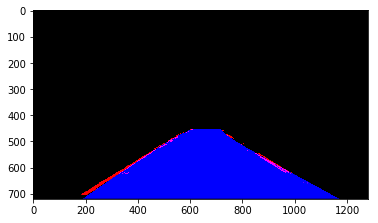

In [194]:
reverse_projected_overlay = RevertBirdsEye(GetNiceOverlay(birds_eye))
plt.imshow(reverse_projected_overlay)

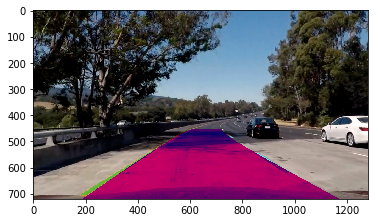

In [221]:
mixed = np.copy(undistorted_img)
r = mixed[:,:,0]
g = mixed[:,:,1]
b = mixed[:,:,2]
r[np.where(reverse_projected_overlay[:,:,0] > 0)] = 100
g[np.where(reverse_projected_overlay[:,:,2] > 0)] = 0
b[np.where(reverse_projected_overlay[:,:,2] > 0)] = 100
plt.imshow(mixed)